In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

In [3]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve()

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

In [4]:
# %time model.simulate_prep()
%time model.simulate()

CPU times: total: 78.1 ms
Wall time: 166 ms


In [5]:
np.mean(model.sim.w[:], axis=0)

array([215.033648  , 221.48359108, 227.51278086, 233.10450047,
       238.24605461, 242.92862913, 247.147109  , 250.89986252,
       254.18849896, 257.01760665, 259.3944781 , 261.32882797,
       262.83250911, 263.91923141, 264.60428718, 264.90428648,
       264.836905  , 264.4206466 , 263.67462185, 262.6183439 ,
       261.271542  , 259.65399312, 257.78537138, 255.6851152 ,
       253.37231121, 250.86559461, 248.18306469, 245.34221483,
       242.35987575, 239.25217099, 236.03448356, 232.72143266,
       229.3268593 , 225.86382002, 222.34458748, 218.78065722,
       221.6258694 , 224.36054001, 226.98552636, 229.5019017 ,
       231.91093631, 234.21407937, 236.41294131, 238.50927697,
       240.5049695 , 242.40201501, 244.20250798, 245.90862751,
       247.52262434, 249.04680873, 250.48353897, 251.83521088,
       253.10424787, 254.29309186, 255.40419481, 256.44001105,
       257.40299017, 258.29557053, 259.12017351, 259.87919811,
       260.57501627, 261.20996863, 261.78636073, 262.30

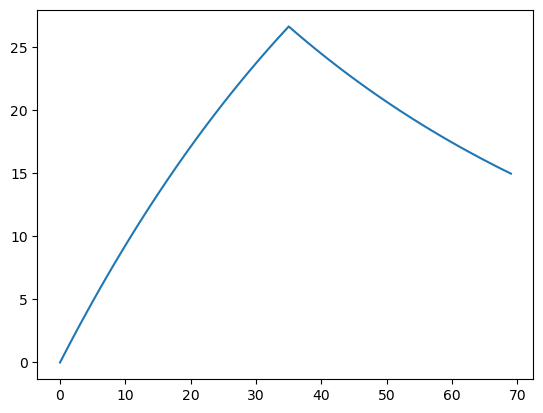

In [6]:
plt.plot(np.arange(par.T),np.mean(model.sim.k[:], axis=0))


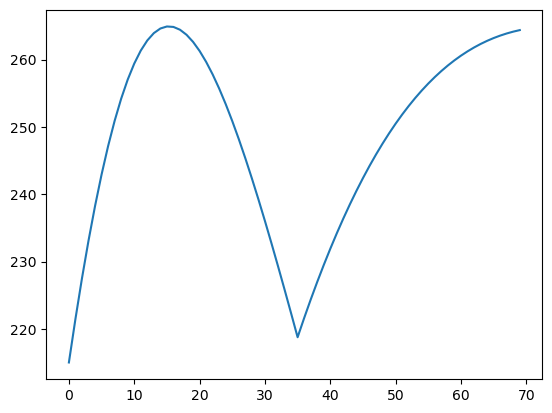

In [7]:
plt.plot(np.arange(par.T),np.mean(model.sim.w[:], axis=0))


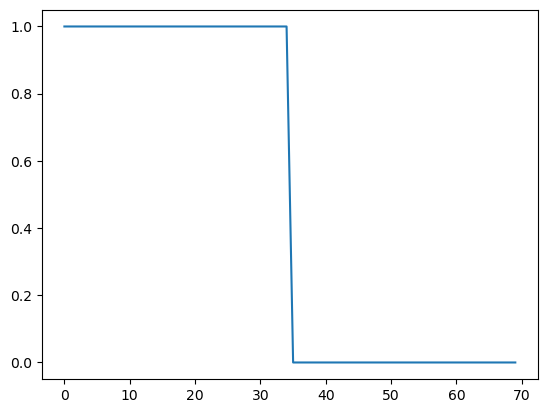

In [8]:
plt.plot(np.arange(par.T),np.mean(model.sim.h[:], axis=0))


In [12]:
model.sim.a[:]

array([[7.01663202e+01, 3.43481759e-07, 7.75973848e-02, 7.39016881e-02,
        4.57717494e-02, 1.11996394e-01, 2.87663773e-02, 1.15563633e-01,
        9.18334584e-02, 9.48308415e-02, 1.28676350e-01, 6.40136453e-02,
        1.47245503e-01, 3.69653204e-02, 1.55135416e-01, 2.38986024e-02,
        1.57222431e-01, 2.94283640e-02, 1.54526049e-01, 5.19813053e-02,
        1.44242787e-01, 8.44480197e-02, 1.20762302e-01, 1.15825420e-01,
        7.73824760e-02, 1.33518392e-01, 8.39423876e-03, 1.25937798e-01,
        6.86186343e-02, 8.50424389e-02, 1.06800642e-01, 8.51726785e-03,
        9.81160136e-02, 6.95934783e-02, 4.36593392e-02, 8.63496243e-02,
        5.47050718e-07, 3.43126544e-07, 3.90116895e-07, 4.47002606e-07,
        5.13690338e-07, 3.67025052e-07, 4.29113243e-07, 3.93338553e-07,
        4.14338899e-07, 4.43555734e-07, 3.16406506e-07, 3.16406513e-07,
        3.16406513e-07, 3.16406521e-07, 3.16406528e-07, 3.16406521e-07,
        3.16406528e-07, 3.16406521e-07, 3.16406521e-07, 3.164065

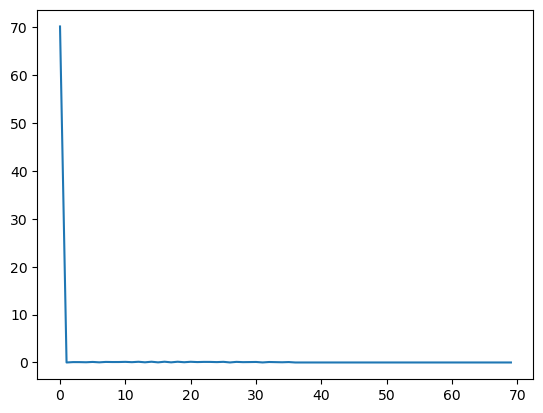

In [9]:
plt.plot(np.arange(par.T),np.mean(model.sim.a[:], axis=0))


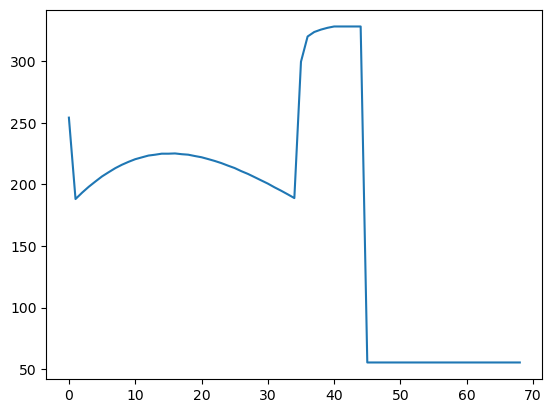

In [10]:
plt.plot(np.arange(par.T),np.mean(model.sim.c[:], axis=0))


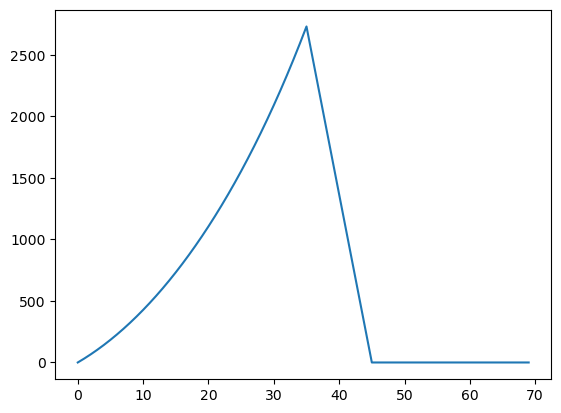

In [11]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


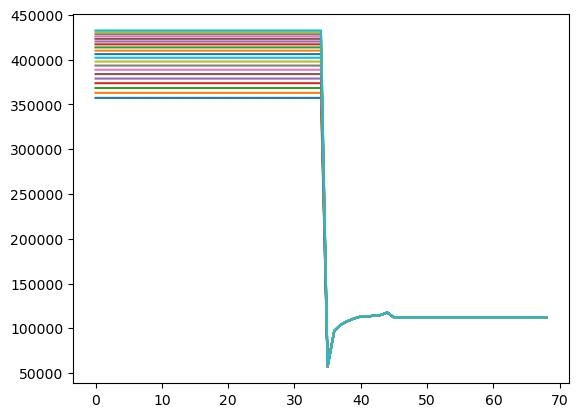

In [7]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [8]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.a[:, 1, 1, i])


AttributeError: 'types.SimpleNamespace' object has no attribute 'a'

In [7]:
sol.V[:, 4, 4, :]

array([[-0.10301868, -0.10294206, -0.10285988, ..., -0.10088155,
        -0.10069532, -0.10049993],
       [-0.10327627, -0.10319965, -0.10311747, ..., -0.10113914,
        -0.10095292, -0.10075752],
       [-0.10356277, -0.10348615, -0.10340397, ..., -0.10142564,
        -0.10123942, -0.10104402],
       ...,
       [-0.21059426, -0.21059426, -0.21059426, ..., -0.21059426,
        -0.21059426, -0.21059426],
       [-0.12337139, -0.12337139, -0.12337139, ..., -0.12337139,
        -0.12337139, -0.12337139],
       [-0.12324888, -0.12324888, -0.12324888, ..., -0.12324888,
        -0.12324888, -0.12324888]])

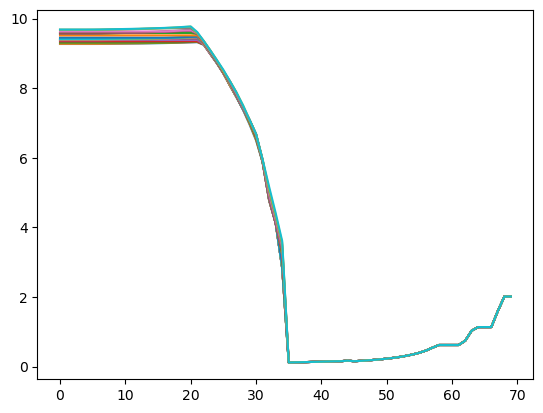

In [8]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 4, 4, i])

In [ ]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
